# Using Pandas to analyse housing prices in US
(Inspired by a tutorial published at www.pythonprogramming.net)

The objective of this tutorial is to analyse the housing prices of 50 states of USA. To do this, we make use of Quandl DB to download the House Price Index by state. 
- Every state is a query to Quandl and it'll retrieve a new DataFrame to be merged into a big DataFrame
- All prices are normalized into percentual values of the first price, by the beginning of the series
- Graphs of states and the country benchmark are plot
- Prices correlations are performed also
- Data is resampled to see yearly trends
- Using rolling windows to check some trends in the data
- Making correlation between mortgage rates and the housing prices
- Trying to find correlation between HPI and a major economic indicator: GDP (Gross Domestic Product)

Example learned from http://www.pythonprogramming.net

In [16]:
import pandas as pd
import quandl
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# using pickle library to persist/recover objects
HPI_STATES_PICKLE_FILE = 'pickle/hpi_states_usa.pickle'
HPI_BENCHMARK_PICKLE_FILE = 'pickle/hpi_benchmark_usa.pickle'

# Flag to force pickle objects updates
FORCE_UPDATE = False

# Key to access Quandl DB
quandl_api_key = open('data/quandl_api_key.txt', 'r').read()
quandl_api_key

'eon-D6FSnS7fa9m8xm34'

In [2]:
# Getting the list of all US states
def get_states_list():
    us_states = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states')
    # The first DataFrame is the desired table and the first columns is the States' abbreviations
    # Excluing the first row ([1:]) as it's the title ("Abbreviation")
    us_states_list = [state for state in us_states[0][0][1:]]
    return us_states_list

In [3]:
def get_hpi_states():
    main_df = pd.DataFrame()
    
    if not FORCE_UPDATE and Path(HPI_STATES_PICKLE_FILE).is_file():
        main_df = pd.read_pickle(HPI_STATES_PICKLE_FILE)
    else:    
        states = get_states_list()

        for state in states:
            df = quandl.get("FMAC/HPI_"+str(state), authtoken=quandl_api_key)
            df.rename(columns={'Value':str(state)}, inplace=True)
    #         df = df.pct_change()
            df[str(state)] = (df[str(state)] - df[str(state)][0]) * 100.0 / df[str(state)][0]

            print("Downloading data of state = "+ state)
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df)
        # Save to pickle file
        main_df.to_pickle(HPI_STATES_PICKLE_FILE)

    return main_df

In [4]:
def get_hpi_benchmark():
    if not FORCE_UPDATE and Path(HPI_BENCHMARK_PICKLE_FILE).is_file():
        df = pd.read_pickle(HPI_BENCHMARK_PICKLE_FILE)
    else: 
        df = quandl.get("FMAC/HPI_USA", authtoken=quandl_api_key)
        df.rename(columns={'Value':'USA_HPI_Benchmark'}, inplace=True)
        df["USA_HPI_Benchmark"] = (df["USA_HPI_Benchmark"]-df["USA_HPI_Benchmark"][0]) * 100.0 / df["USA_HPI_Benchmark"][0]
        df.to_pickle(HPI_BENCHMARK_PICKLE_FILE)
    return df

In [5]:
def get_mortgage_rates():
    df = quandl.get("FMAC/MORTG", trim_start="1975-01-01", authtoken=quandl_api_key)
    df.columns = ['Mortgage']
    # Putting it in percentual values
    df['Mortgage'] = (df['Mortgage'] - df['Mortgage'][0]) * 100.0/df['Mortgage'][0]
    # NOTE: Mortgage rates return data on the 1st day of the month, rather than end of month
    #       So, to make joinable with the other Dataframes we go with a little workaround:
    #       - Resample for a daily sample (all other days rather than the 1st will be NaN)
    #       - Resample for a monthly sample (pandas will put the new value in the last day)
    df = df.resample('1D').mean()
    df = df.resample('M').mean()

    return df

In [25]:
def get_sp500_rates():
    df = pd.read_csv('data/SP500.csv', delimiter=',', index_col=0)
    df = pd.DataFrame(df['Close'], pd.to_datetime(df.index))
    df.columns = ['SP500']
    # Putting it in percentual values
    df['SP500'] = (df['SP500'] - df['SP500'][0]) * 100.0/df['SP500'][0]
    # NOTE: S&P 500 rates are stored based-on tge 1st day of the month, rather than end of month
    #       So, to make joinable with the other Dataframes we go with a little workaround:
    #       - Resample for a daily sample (all other days rather than the 1st will be NaN)
    #       - Resample for a monthly sample (pandas will put the new value in the last day)
    df = df.resample('1D').mean()
    df = df.resample('M').mean()
    
    return df

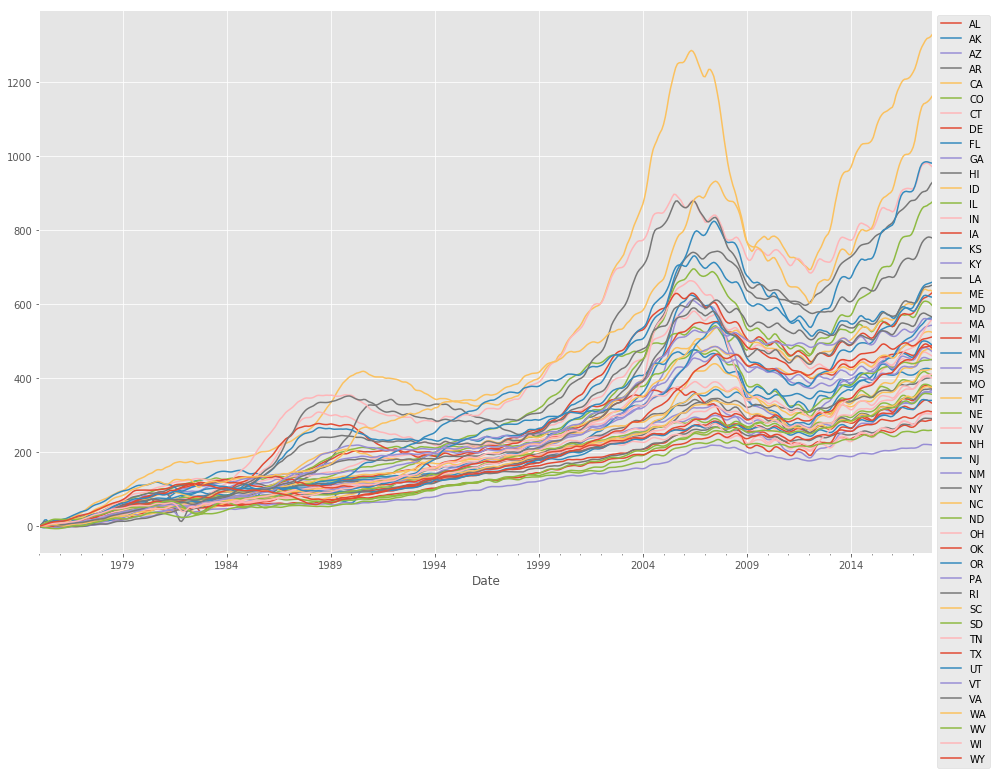

In [7]:
## Plotting HPI states graph
df_states = get_hpi_states()

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

df_states.plot(ax=ax1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

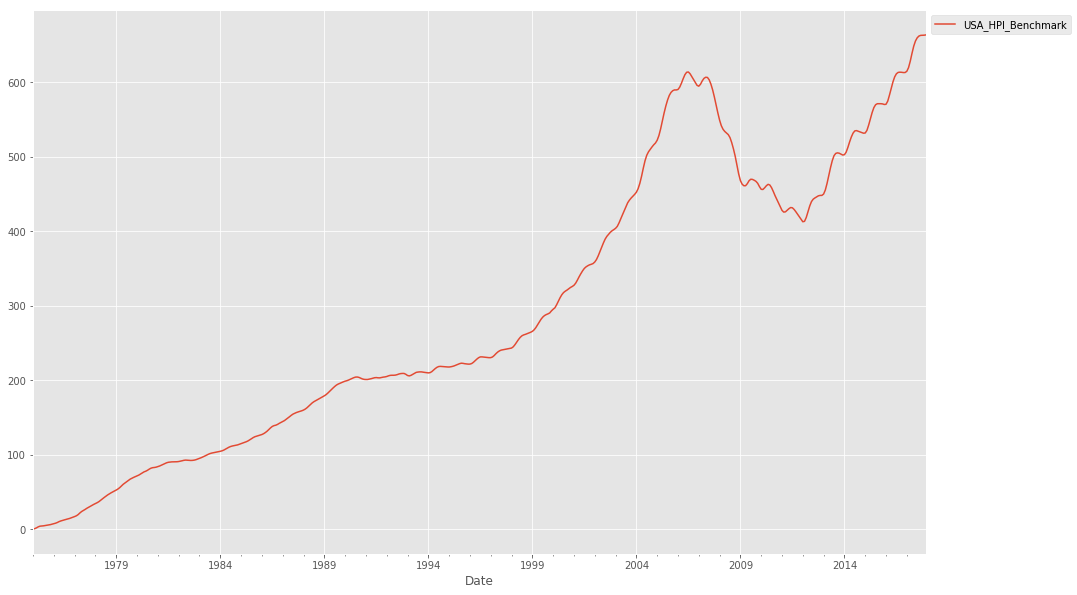

In [8]:
# Plotting benchmark of HPI in USA
df_benchmark = get_hpi_benchmark()
plt.clf()

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

df_benchmark.plot(ax=ax1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

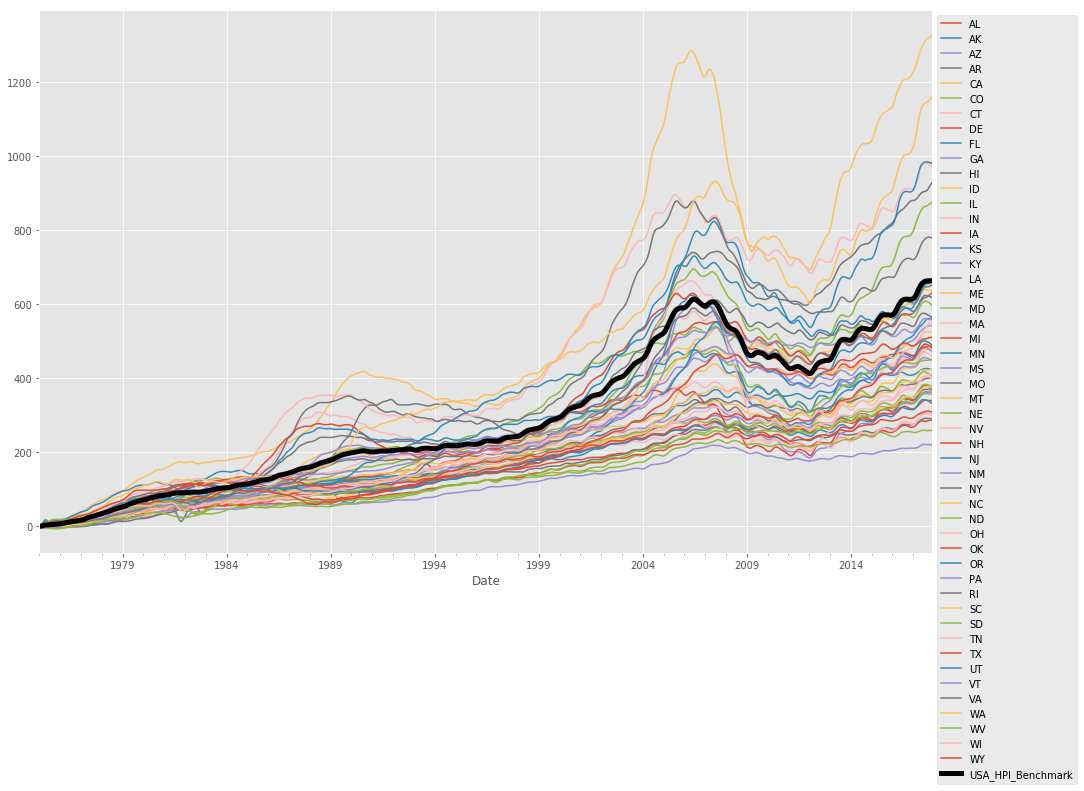

In [9]:
# It looks like we have a tendency among all states, so now putting it all together
plt.clf()

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

df_states.plot(ax=ax1)
df_benchmark.plot(color='k',ax=ax1, linewidth=5)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

ND    0.743941
NV    0.743941
Name: min, dtype: float64


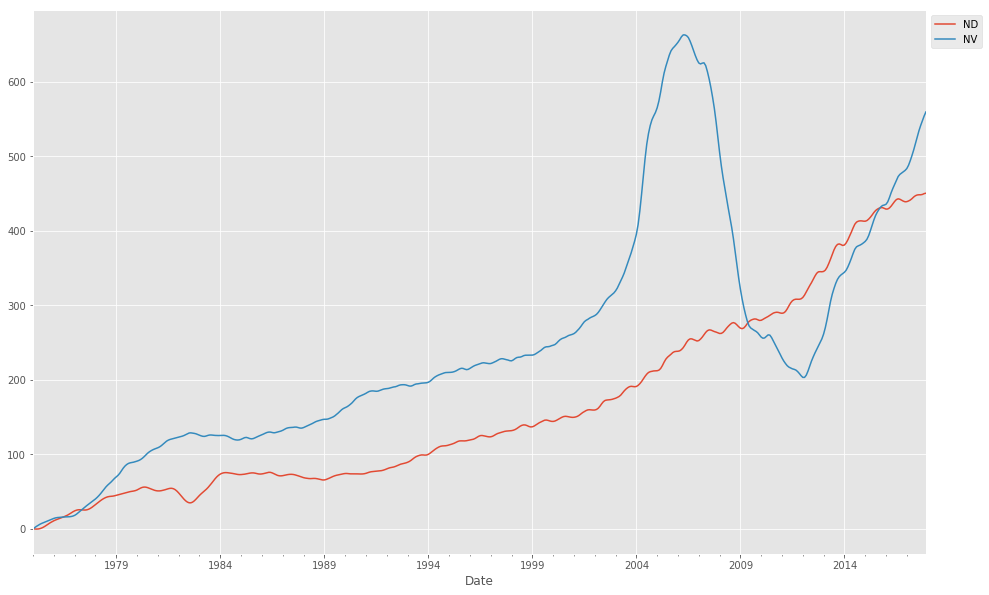

In [10]:
# To analyse the tendency we look into the correlation of HPI states 
correlation = df_states.corr()

# Minimum correlation - the minimum two states in the describe().min list
minimum_correlation_series = correlation.describe().loc['min']
two_least_correlated = minimum_correlation_series.sort_values()[:2].index
df_two_least_correlated = df_states[two_least_correlated]
print(minimum_correlation_series.sort_values()[:2])

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

df_two_least_correlated.plot(ax=ax1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

            USA_HPI_Benchmark
Date                         
1975-12-31           3.826020
1976-12-31          11.740859
1977-12-31          25.287356
1978-12-31          42.977835
1979-12-31          62.176865


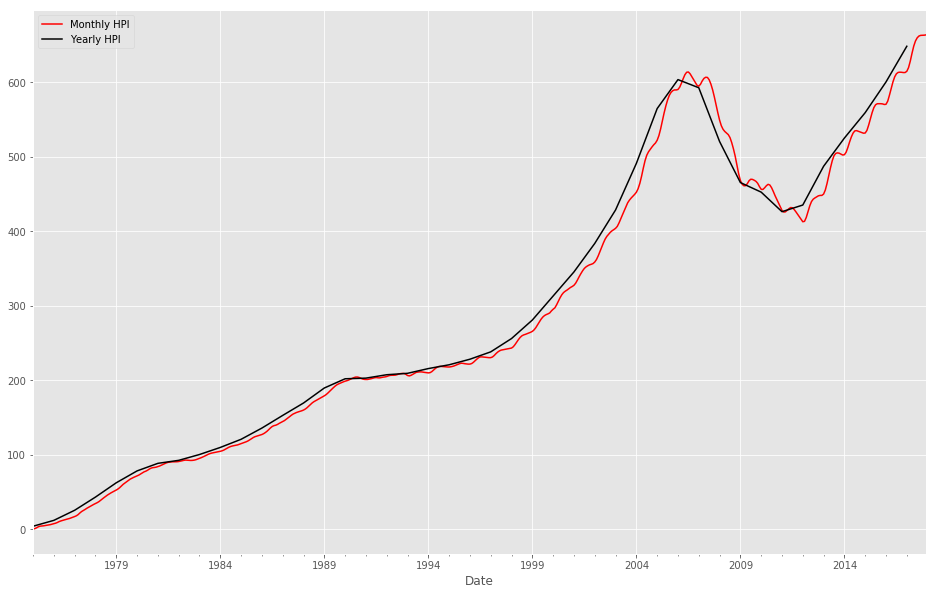

In [11]:
# Now let's try some resampling by year ('A') to find some trend
# Data will be resampled with the mean of all month values

# Resample rules:
# xL for milliseconds
# xMin for minutes
# xD for Days

# Alias	Description
# B	business day frequency
# C	custom business day frequency (experimental)
# D	calendar day frequency
# W	weekly frequency
# M	month end frequency
# BM	business month end frequency
# CBM	custom business month end frequency
# MS	month start frequency
# BMS	business month start frequency
# CBMS	custom business month start frequency
# Q	quarter end frequency
# BQ	business quarter endfrequency
# QS	quarter start frequency
# BQS	business quarter start frequency
# A	year end frequency
# BA	business year end frequency
# AS	year start frequency
# BAS	business year start frequency
# BH	business hour frequency
# H	hourly frequency
# T	minutely frequency
# S	secondly frequency
# L	milliseonds
# U	microseconds
# N	nanoseconds
monthly_df = df_benchmark
yearly_df = monthly_df.resample('A').mean()

print(yearly_df.head())

plt.clf()

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

monthly_df.plot(color='r', ax=ax1)
yearly_df.plot(color='k',ax=ax1)
plt.legend(['Monthly HPI', 'Yearly HPI'])
plt.show()

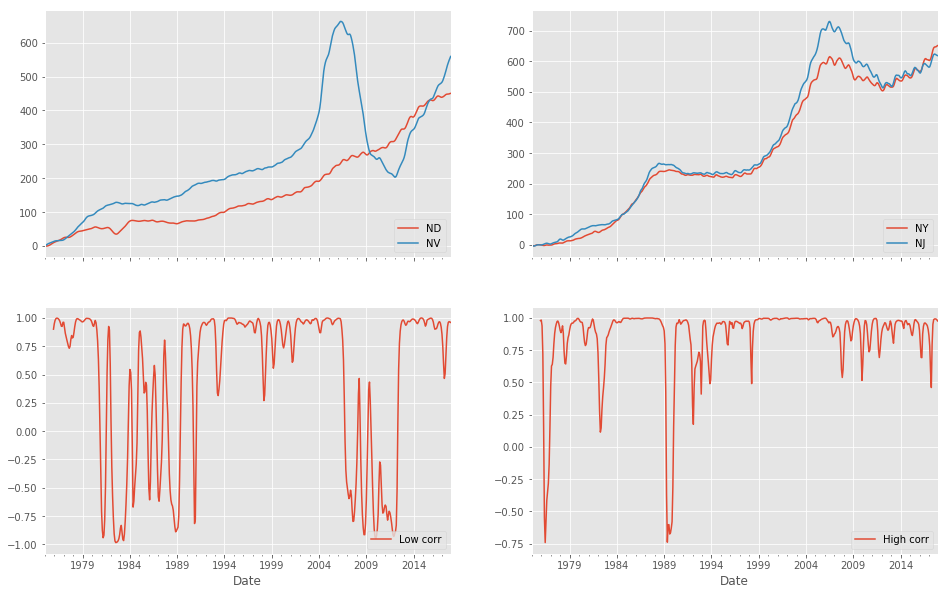

In [12]:
# Now let's try some rolling to find the standard deviation on a window of 12 months 
# between the two least correlated states
state1 = two_least_correlated[0]
state2 = two_least_correlated[1]
# Also trying some rolling with two close states, and we hope to find a high correlation most of the time :)
state3 = 'NY'
state4 = 'NJ'

rolling_correlation_left = df_states[state1].rolling(window=12).corr(df_states[state2])
rolling_correlation_right = df_states[state3].rolling(window=12).corr(df_states[state4])

plt.clf()
fig = plt.figure(figsize=(16, 10))

# Plotting two graphs, the first parameter says it has 2 components vertically and 2 horizontally
#                      the second parameter says in what coordinate this axis should be drawn (0-based)
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0), sharex=ax1)
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1), sharex=ax3)

# On the left we have the least correlated states
df_states[state1].plot(ax=ax1, label=state1)
df_states[state2].plot(ax=ax1, label=state2)
ax1.legend(loc=4)
rolling_correlation_left.plot(ax=ax2, label="Low corr")
ax2.legend(loc=4)

# On the right we have some neighbour states
df_states[state3].plot(ax=ax3, label=state3)
df_states[state4].plot(ax=ax3, label=state4)
ax3.legend(loc=4)
rolling_correlation_right.plot(ax=ax4, label="High corr")
ax4.legend(loc=4)

plt.show()

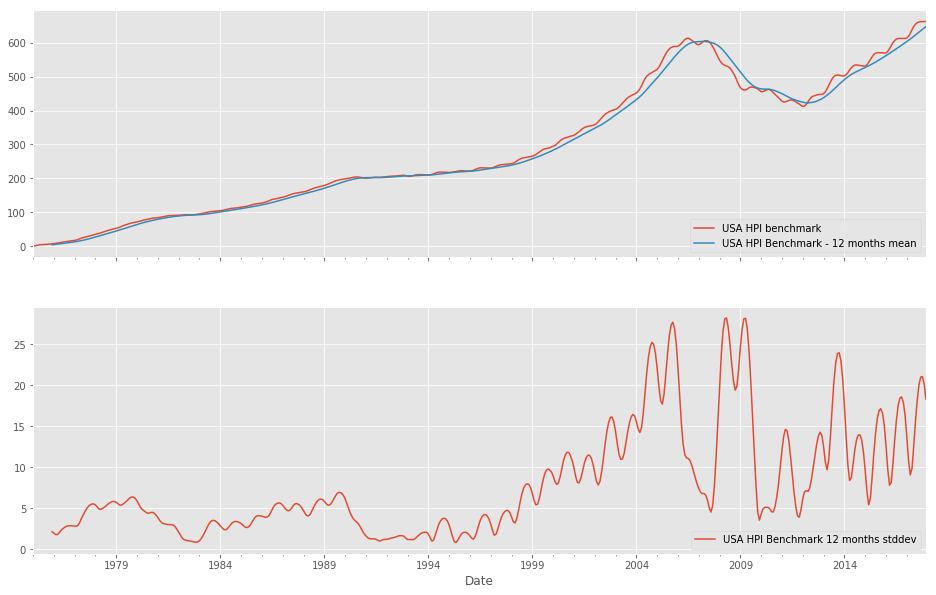

In [13]:
# Calculating the rolling window of mean using the benchmark
df_benchmark['USA_HPI_Benchmark12Mean'] = df_benchmark['USA_HPI_Benchmark'].rolling(window=12).mean()
# Calculating the rolling window of standard deviation using the benchmark
df_benchmark['USA_HPI_Benchmark12Stddev'] = df_benchmark['USA_HPI_Benchmark'].rolling(window=12).std()

# As the standard deviation is in another scale 
# we should draw it in another imn another axis
# NOTE: As the benchmark has a higher slope, the stddev goes higher
plt.clf()
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

df_benchmark[['USA_HPI_Benchmark', 'USA_HPI_Benchmark12Mean']].plot(ax=ax1)
ax1.legend(['USA HPI benchmark', 'USA HPI Benchmark - 12 months mean'], loc=4)
df_benchmark['USA_HPI_Benchmark12Stddev'].plot(ax=ax2)
ax2.legend(['USA HPI Benchmark 12 months stddev'], loc=4)

plt.show()


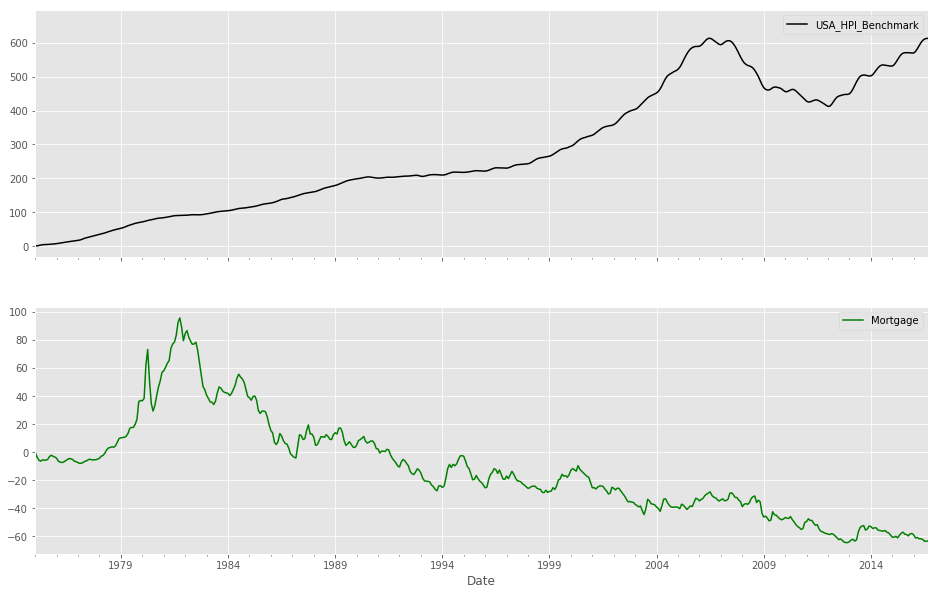

,Mortgage,USA_HPI_Benchmark
Mortgage,1.000000,-0.778378
USA_HPI_Benchmark,-0.778378,1.000000


In [18]:
df_mortgage = get_mortgage_rates()
df_benchmark = get_hpi_benchmark()

plt.clf()

fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

df_benchmark.plot(ax=ax1, c='k')
df_mortgage.plot(ax=ax2, c='g')

plt.show()

# Joining data to run the correlation
df_joined = df_mortgage.join(df_benchmark)
# Graphically we see it's a pretty negative correlation, but how much?
df_joined.corr()


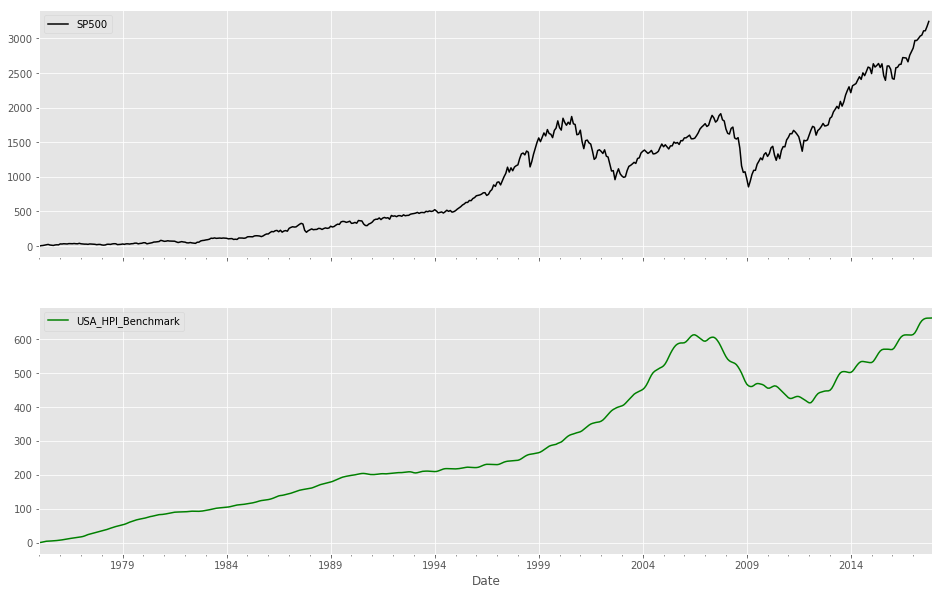

,SP500,USA_HPI_Benchmark
SP500,1.000000,0.911792
USA_HPI_Benchmark,0.911792,1.000000


In [28]:
df_sp500 = get_sp500_rates()
df_benchmark = get_hpi_benchmark()

plt.clf()

fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

df_sp500.plot(ax=ax1, c='k')
df_benchmark.plot(ax=ax2, c='g')

plt.show()

# Joining data to run the correlation
df_joined = df_sp500.join(df_benchmark)
# Graphically we see it's a pretty negative correlation, but how much?
df_joined.corr()